In [1]:
import pandas as pd
import numpy as np
import copy, re, time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [2]:
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import statistics
from warnings import simplefilter

In [3]:
# 讀取訓練與測試資料
data_path = '/Users/gary/Machine_Learning/Kaggle練習/house_prices_advanced_regression_techniques/'
df_train = pd.read_csv(data_path + 'train.csv')
df_test = pd.read_csv(data_path + 'test.csv')

# Explore / Drop Outliners

In [6]:
# 價格分佈
# sns.distplot(df_train['SalePrice'], bins=15)

In [7]:
# df_train['SalePrice'].describe()

In [8]:
# sns.regplot(x = df_train['GrLivArea'], y=df_train['SalePrice'])

In [9]:
# df_train['SalePrice'].mean()+4.174*df_train['SalePrice'].std()

In [4]:
# 修正 df_train 去 outliners
df_train = df_train[df_train['GrLivArea']<4000]
df_train = df_train[df_train['SalePrice']<df_train['SalePrice'].mean()+4.174*df_train['SalePrice'].std()]

In [5]:
# 抽離出 saleprice / train_Y / train_num
saleprice = df_train['SalePrice']
train_Y = np.log1p(df_train['SalePrice'])
train_num = train_Y.shape[0]

In [6]:
# # 修正價格分佈
# sns.distplot(df_train['SalePrice'], bins=15)

In [7]:
# df_train['SalePrice'].describe()

In [8]:
# sns.regplot(x = df_train['GrLivArea'], y=saleprice)

In [9]:
# # 修正 log 價格分佈
# sns.distplot(train_Y, bins=15)

In [10]:
# train_Y.describe()

In [11]:
# sns.regplot(x = df_train['GrLivArea'], y=train_Y)
# plt.show()

# Min Feature Engineering & Evaluate

In [12]:
# 將 train_X, test_X 該有的資料合併成 df, 作特徵工程
# 抽離出 ids
ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train,df_test])

In [13]:
# check_list = [i for i in df.select_dtypes(exclude=["object"]).columns if df[i].min()==0]
# for i in check_list:
#     plt.figure()
#     sns.distplot(df[~df[i].isnull()][i], bins=15, kde=False)

In [22]:
# 評估用表格
# df_removal = df.copy()

In [13]:
# # 特徵工程-簡化版 : 全部空值先補mean, 所有類別欄位先做 LabelEncoder, 然後再與數字欄位做 StandardScaler
# LEncoder = LabelEncoder()
# STDEncoder = StandardScaler()

# for c in df_removal.columns:
#     if df_removal[c].dtype == 'object': # 如果是文字型 / 類別型欄位, 就先補缺 'None' 後, 再做標籤編碼
#         df_removal[c] = df_removal[c].fillna('None')
#         df_removal[c] = LEncoder.fit_transform(df_removal[c]) 
#     else: # 其他狀況(本例其他都是數值), 就補缺 mean
#         df_removal[c] = df_removal[c].fillna(value=df_removal[c].mean())
#         df_removal[c] = STDEncoder.fit_transform(df_removal[c].values.reshape(-1, 1))

In [14]:
# x_train, x_test, y_train, y_test = train_test_split(df_removal[:train_num], train_Y, test_size=0.25, random_state=4)

In [15]:
# # RandomForestRegressor 對照分數
# clf = RandomForestRegressor()
# clf.fit(x_train, y_train)
# y_pred = clf.predict(x_test)
# r2 = r2_score(y_pred, y_test) # 使用 r-square 評估
# print("R-square: ", r2)

In [16]:
# # LinearRegression 對照分數
# reg = LinearRegression()
# reg.fit(x_train, y_train)
# y_pred = reg.predict(x_test)
# r2 = r2_score(y_pred, y_test) # 使用 r-square 評估
# print("R-square: ", r2)

In [18]:
linear = LinearRegression(normalize=True, fit_intercept=True, copy_X=True)
# linear = LinearRegression()
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
                                 max_depth=6, learning_rate=0.03)
# rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
#                            max_features='sqrt', max_depth=8, bootstrap=False)
rf = RandomForestRegressor()

In [19]:
def generate_removal(df):
    df_removal = df.copy()
    # 特徵工程-簡化版 : 全部空值先補mean, 所有類別欄位先做 LabelEncoder, 然後再與數字欄位做 StandardScaler
    LEncoder = LabelEncoder()
    STDEncoder = StandardScaler()

    for c in df_removal.columns:
        if df_removal[c].dtype == 'object': # 如果是文字型 / 類別型欄位, 就先補缺 'None' 後, 再做標籤編碼
            df_removal[c] = df_removal[c].fillna('None')
            df_removal[c] = LEncoder.fit_transform(df_removal[c]) 
        else: # 其他狀況(本例其他都是數值), 就補缺 mean
            df_removal[c] = df_removal[c].fillna(value=df_removal[c].mean())
            df_removal[c] = STDEncoder.fit_transform(df_removal[c].values.reshape(-1, 1))
    return df_removal

In [20]:
def evaluate_train(df, estimator):
    x_train, x_test, y_train, y_test = train_test_split\
    (df[:train_num], train_Y, test_size=0.25, random_state=4)
    est = estimator
    est.fit(x_train, y_train)
    y_pred = est.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    return round(r2, 4)

In [21]:
def mean_evaluate(df, estimator=gdbt, iterate_times=5):
    simplefilter(action='ignore', category=FutureWarning)
    base = [evaluate_train(df, estimator) for i in range(iterate_times)]
    score = round(statistics.mean(base), 4)
    return score

In [22]:
def tmp_pred(df, estimator):
    train_num = train_Y.shape[0]
    train_X = df[:train_num]
    test_X = df[train_num:]
    est = estimator
    est.fit(train_X, train_Y)
    pred = est.predict(test_X)
    pred = np.expm1(pred)
    upld = pd.DataFrame({'Id':ids, 'SalePrice':pred})
    return upld

In [23]:
df_removal = generate_removal(df)

In [26]:
print(f'rf score: {mean_evaluate(df_removal, rf)}')
print(f'linear score: {evaluate_train(df_removal, linear)}')
print(f'gdbt score: {mean_evaluate(df_removal, gdbt)}')

rf score: 0.8583
linear score: 0.9087
gdbt score: 0.9145


In [33]:
# tree not fit!

In [29]:
upld = tmp_pred(df_removal, gdbt)
upld.SalePrice = upld.SalePrice.apply(lambda x:600000 if x>600000 else x)
upld.SalePrice = upld.SalePrice.apply(lambda x:34000 if x<34000 else x)

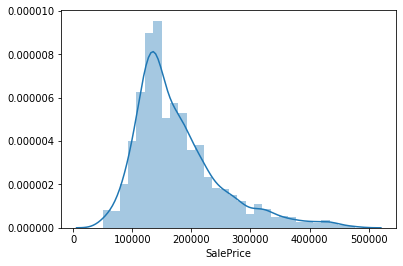

In [30]:
sns.distplot(upld.SalePrice)

In [33]:
# 0.12871
upld.to_csv('housing_gdbt_baseline.csv', index=False)

In [34]:
upld = tmp_pred(df_removal, linear)
upld.SalePrice = upld.SalePrice.apply(lambda x:600000 if x>600000 else x)
upld.SalePrice = upld.SalePrice.apply(lambda x:34000 if x<34000 else x)

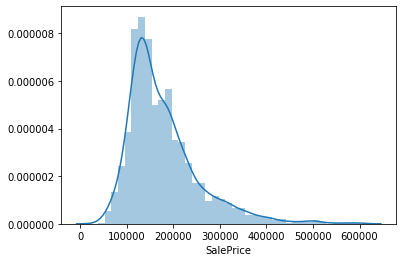

In [35]:
sns.distplot(upld.SalePrice)

In [38]:
# 0.12862
upld.to_csv('housing_lin_baseline.csv', index=False)

In [21]:
# def decide_imp(df_t):
#     df_removal = df_t.copy()
    
#     LEncoder = LabelEncoder()
#     STDEncoder = StandardScaler()

#     for c in df_removal.columns:
#         if df_removal[c].dtype == 'object': # 如果是文字型 / 類別型欄位, 就先補缺 'None' 後, 再做標籤編碼
#             df_removal[c] = df_removal[c].fillna('None')
#             df_removal[c] = LEncoder.fit_transform(df_removal[c]) 
#         else: # 其他狀況(本例其他都是數值), 就補缺 mean
#             df_removal[c] = df_removal[c].fillna(value=df_removal[c].mean())
#             df_removal[c] = STDEncoder.fit_transform(df_removal[c].values.reshape(-1, 1))
#     train_X_removal = df_removal[:train_num]

#     x_train, x_test, y_train, y_test = train_test_split(train_X_removal, train_Y, test_size=0.25, random_state=4)
#     clf = RandomForestRegressor()
#     clf.fit(x_train, y_train)
    
#     imp = pd.DataFrame({'cols': df_removal.columns,'imp':clf.feature_importances_})
#     return imp

In [23]:
# from functools import reduce
# imps = [decide_imp(df) for i in range(5)]
# imps[0].columns=['cols', 'imp_a']
# imps[1].columns=['cols', 'imp_b']
# imps[2].columns=['cols', 'imp_c']
# imps[3].columns=['cols', 'imp_d']
# imps[4].columns=['cols', 'imp_e']

In [24]:
# df_imp = reduce(lambda left,right: pd.merge(left,right,on='cols'), imps)
# df_imp['imp'] = (df_imp['imp_a']+df_imp['imp_b']+df_imp['imp_c']+df_imp['imp_d']+df_imp['imp_e'])/5
# df_imp = df_imp.drop(['imp_a','imp_b','imp_c','imp_d','imp_e'], axis=1).sort_values('imp',ascending = True)

In [25]:
# imp_sort = list(imp['cols'])[::-1]

In [118]:
# def evaluate(df_t, columns):
#     df_removal = df_t[columns]
    
#     LEncoder = LabelEncoder()
#     STDEncoder = StandardScaler()

#     for c in df_removal.columns:
#         if df_removal[c].dtype == 'object': # 如果是文字型 / 類別型欄位, 就先補缺 'None' 後, 再做標籤編碼
#             df_removal[c] = df_removal[c].fillna('None')
#             df_removal[c] = LEncoder.fit_transform(df_removal[c]) 
#         else: # 其他狀況(本例其他都是數值), 就補缺 mean
#             df_removal[c] = df_removal[c].fillna(value=df_removal[c].mean())
#             df_removal[c] = STDEncoder.fit_transform(df_removal[c].values.reshape(-1, 1))
#     train_X_removal = df_removal[:train_num]

#     simplefilter(action='ignore', category=FutureWarning)
#     x_train, x_test, y_train, y_test = train_test_split(train_X_removal, train_Y, test_size=0.25, random_state=4)
#     clf = RandomForestRegressor()
#     clf.fit(x_train, y_train)
#     y_pred = clf.predict(x_test)

#     r2 = r2_score(y_pred, y_test)
#     return r2

In [69]:
# mean_evaluate(evaluate, imp_sort, 86)

In [70]:
# lad = [mean_evaluate(evaluate, imp_sort, i) for i in range(1, 87)]

In [71]:
# data = pd.DataFrame({'removed_cols': list(range(0, 86)),'score':lad})
# sns.scatterplot(x='removed_cols', y='score', data=data)

In [73]:
# mean_evaluate(evaluate, imp_sort, 61)

In [74]:
# # 有影響的特徵
# imp_faetures = imp_sort[:-61]

In [75]:
# df = df[imp_faetures] 

In [76]:
# df_removal = df.copy()

# LEncoder = LabelEncoder()
# STDEncoder = StandardScaler()

# for c in df_removal.columns:
#     if df_removal[c].dtype == 'object': # 如果是文字型 / 類別型欄位, 就先補缺 'None' 後, 再做標籤編碼
#         df_removal[c] = df_removal[c].fillna('None')
#         df_removal[c] = LEncoder.fit_transform(df_removal[c]) 
#     else: # 其他狀況(本例其他都是數值), 就補缺 mean
#         df_removal[c] = df_removal[c].fillna(value=df_removal[c].mean())
#         df_removal[c] = STDEncoder.fit_transform(df_removal[c].values.reshape(-1, 1))


# # train_num = train_Y.shape[0]
# # train_X = df_removal[:train_num]
# # test_X = df_removal[train_num:]

In [40]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
# comparing_score = mean_evaluate(df_removal, gdbt, 30)
print(comparing_score)

0.9087


# Missing Column

In [39]:
# df.columns.sort_values(ascending=False)

In [41]:
# # 檢查欄位缺值數量
# missing = df.isnull().sum()[lambda x:x>0].sort_values(ascending=False)
# plt.figure(figsize=(8, 12))
# sns.barplot(missing, missing.index)

In [43]:
for i in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    df_removal = generate_removal(df.drop([i], axis=1))
    print(i, round(evaluate_train(df_removal, linear) - comparing_score, 4))

PoolQC -0.0022
MiscFeature 0.0016
Alley 0.0017
Fence -0.0005
FireplaceQu -0.0006


In [44]:
df_removal = generate_removal(df.drop(['MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1))
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.001

In [45]:
df = df.drop(['MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

In [46]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9097


In [47]:
# 分開處理類別/數值欄位
object_features = list(df.select_dtypes(include=["object"]).columns)
numeric_features = list(df.select_dtypes(exclude=["object"]).columns)

In [48]:
for i in object_features:
    df[i] = df[i].fillna('None')

In [49]:
# 檢查欄位缺值數量
missing = df.isnull().sum()[lambda x:x>0].sort_values(ascending=False)
missing

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64

In [50]:
df_removal = df.copy()

df_removal['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# df_temp = df_removal[(~df_removal['LotFrontage'].isnull()) & (df_removal['LotFrontage'] < 100000)]
# reg = LinearRegression()
# reg.fit(np.array(df_temp['LotArea']).reshape(-1, 1), df_temp['LotFrontage'])
# df_removal['LotFrontage'] = df_removal['LotFrontage'].fillna(reg.intercept_+df_removal['LotArea']*reg.coef_[0])
df_removal = generate_removal(df_removal)
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.0002

In [51]:
# df_temp = df[(~df['LotFrontage'].isnull()) & (df['LotFrontage'] < 100000)]
# reg = LinearRegression()
# reg.fit(np.array(df_temp['LotArea']).reshape(-1, 1), df_temp['LotFrontage'])
# df['LotFrontage'] = df['LotFrontage'].fillna(reg.intercept_+df['LotArea']*reg.coef_[0])
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [52]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
for i in ['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageArea', 'MasVnrArea']:
    df[i] = df[i].fillna(value=df[i].median())
from statistics import mode
for i in ['BsmtHalfBath', 'GarageCars', 'BsmtFullBath']:
    df[i] = df[i].fillna(mode(df[i]))

In [53]:
# df.isnull().sum()[lambda x:x>0].sort_values(ascending=False)

In [54]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9092


# Feature Engineering / Further Exploration

In [55]:
df_removal = df.copy()
df_removal['TotalSF'] = df_removal['TotalBsmtSF'] + df_removal['1stFlrSF'] + df_removal['2ndFlrSF']
df_removal = generate_removal(df_removal)
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.0001

In [56]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [57]:
t_list = ['MasVnrArea', '2ndFlrSF', 'HalfBath', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'BsmtFullBath']
for i in t_list:
    df_removal = df.copy()
    df_removal[f'Has{i}'] = df_removal[i].apply(lambda x: 1 if x > 0 else 0)
    df_removal = df_removal.drop(i, axis=1)
    df_removal = generate_removal(df_removal)
    print(i, round(evaluate_train(df_removal, linear) - comparing_score, 4))

MasVnrArea -0.0001
2ndFlrSF 0.0003
HalfBath -0.0001
Fireplaces 0.0011
WoodDeckSF -0.0003
OpenPorchSF 0.0
BsmtFullBath 0.0


In [58]:
for i in ['2ndFlrSF', 'Fireplaces']:
    df[f'Has{i}'] = df[i].apply(lambda x: 1 if x > 0 else 0)
df = df.drop('2ndFlrSF', axis=1)

In [59]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9097


In [60]:
def evaluate_importance(df, evaluate_columns, comparing_score):
    scores = [evaluate_train(generate_removal(df.drop(i, axis=1)), linear) for i in evaluate_columns]
    imp = pd.DataFrame({'removed_cols':evaluate_columns, \
                        'score_variation':[i-comparing_score for i in scores]}).sort_values\
                        ('score_variation',ascending = False)
    return imp

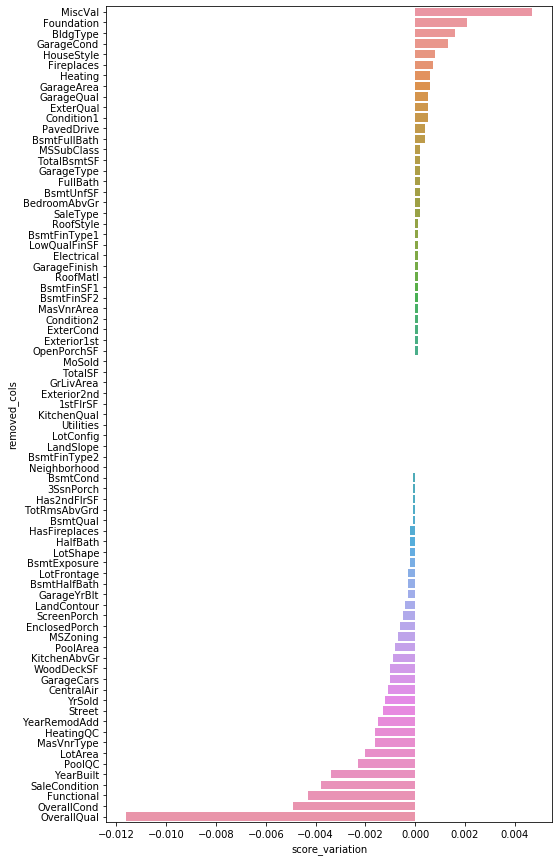

In [61]:
imp = evaluate_importance(df, df.columns, comparing_score)
plt.figure(figsize=(8, 15))
sns.barplot(x='score_variation', y='removed_cols', data=imp)

In [62]:
imp.head()

,removed_cols,score_variation
69,MiscVal,0.0047
27,Foundation,0.0021
13,BldgType,0.0016
60,GarageCond,0.0013
14,HouseStyle,0.0008


In [63]:
df = df.drop(['MiscVal', 'Foundation', 'BldgType'], axis=1)

In [64]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9154


In [65]:
# 分開處理類別/數值欄位
object_features = list(df.select_dtypes(include=["object"]).columns)
numeric_features = list(df.select_dtypes(exclude=["object"]).columns)
ordinal = ['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', \
           'FullBath', 'GarageCars', 'MSSubClass', 'KitchenAbvGr', \
           'MoSold', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd']
for i in ordinal:
    object_features.append(i)
    numeric_features.remove(i)

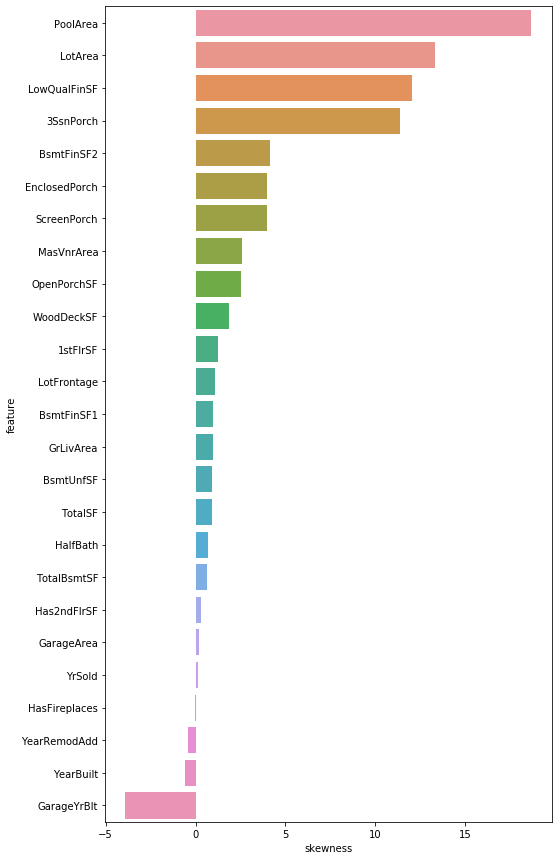

In [66]:
from scipy.stats import skew
skew = pd.DataFrame(df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False))\
    .reset_index().rename(columns={0:'skewness', 'index':'feature'})
plt.figure(figsize=(8, 15))
sns.barplot(x='skewness',y='feature',data=skew)

In [100]:
skewed_feats = list(skew[skew.skewness > 0.5].feature)

In [101]:
print(skewed_feats)

['PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', '1stFlrSF', 'LotFrontage', 'BsmtFinSF1', 'GrLivArea', 'BsmtUnfSF', 'TotalSF', 'HalfBath', 'TotalBsmtSF']


In [102]:
df_removal = df.copy()
df_removal[skewed_feats] = np.log1p(df_removal[skewed_feats])
df_removal = generate_removal(df_removal)
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.0059

In [103]:
df[skewed_feats] = np.log1p(df[skewed_feats])
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9213


In [104]:
# df_removal = df.copy()
# df_removal['BYears'] = 2010 -df_removal['YearBuilt']
# df_removal = df_removal.drop('YearBuilt', axis=1)
# df_removal = generate_removal(df_removal)
# round(evaluate_train(df_removal, linear) - comparing_score, 4)

In [105]:
# df_removal = df.copy()
# df_removal['RemodAddYears'] = 2010 -df_removal['YearRemodAdd']
# df_removal = df_removal.drop('YearRemodAdd', axis=1)
# df_removal = generate_removal(df_removal)
# round(evaluate_train(df_removal, linear) - comparing_score, 4)

In [106]:
# df_removal = df.copy()
# df_removal['SYears'] = 2010 -df_removal['YrSold']
# df_removal = df_removal.drop('YrSold', axis=1)
# df_removal = generate_removal(df_removal)
# round(evaluate_train(df_removal, linear) - comparing_score, 4)

In [107]:
# df_removal['GYears'] = 2010 - df_removal['GarageYrBlt']
# def f(x):
#     if x==2010:
#         return 999  
#     elif x==-197:
#         return 0
#     else:
#         return x
# df_removal['GYears'] = df_removal['GYears'].apply(f)
# df_removal = df_removal.drop('GarageYrBlt', axis=1)
# df_removal = generate_removal(df_removal)
# round(evaluate_train(df_removal, linear) - comparing_score, 4)

In [168]:
# df['BYears'] = 2010 - df['YearBuilt']
# df['RemodAddYears'] = 2010 - df['YearRemodAdd']
# df['GYears'] = 2010 - df['GarageYrBlt']
# df['SYears'] = 2010 - df['YrSold']
# def f(x):
#     if x==2010:
#         return 999  
#     elif x==-197:
#         return 0
#     else:
#         return x
# df['GYears'] = df['GYears'].apply(f)

In [108]:
# 分開處理類別/數值欄位
object_features = list(df.select_dtypes(include=["object"]).columns)
numeric_features = list(df.select_dtypes(exclude=["object"]).columns)
ordinal = ['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', \
           'FullBath', 'GarageCars', 'MSSubClass', 'KitchenAbvGr', \
           'MoSold', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd']
for i in ordinal:
    object_features.append(i)
    numeric_features.remove(i)

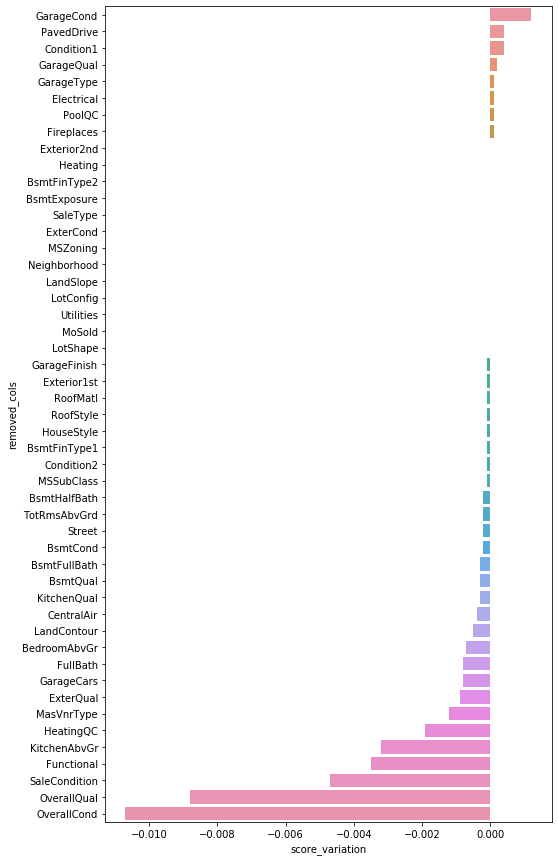

In [114]:
imp = evaluate_importance(df, object_features, comparing_score)
plt.figure(figsize=(8, 15))
sns.barplot(x='score_variation', y='removed_cols', data=imp)

In [115]:
imp[imp['score_variation']>0]

,removed_cols,score_variation
32,GarageCond,0.0012
33,PavedDrive,0.0004
8,Condition1,0.0004
31,GarageQual,0.0002
29,GarageType,0.0001
26,Electrical,0.0001
34,PoolQC,0.0001
40,Fireplaces,0.0001


In [112]:
# df_removal = generate_removal(df)
# comparing_score = evaluate_train(df_removal, linear)
# print(comparing_score)

In [213]:
# df.head()

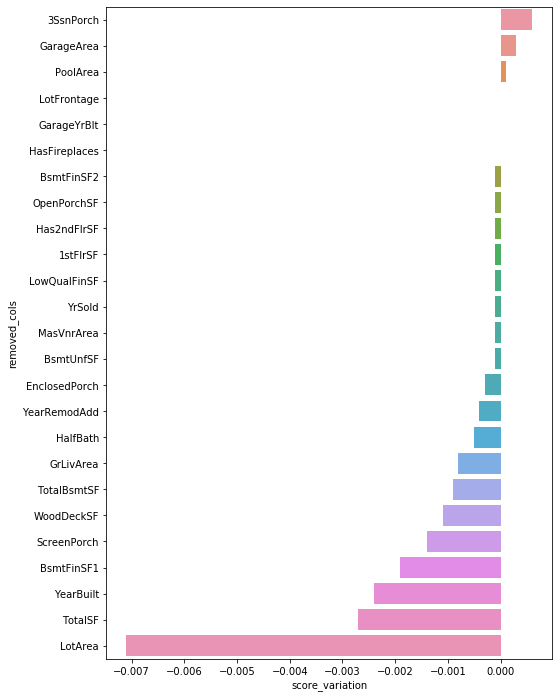

In [117]:
imp = evaluate_importance(df, numeric_features, comparing_score)
plt.figure(figsize=(8, 12))
sns.barplot(x='score_variation', y='removed_cols', data=imp)

In [118]:
imp[imp['score_variation']>0]

,removed_cols,score_variation
18,3SsnPorch,0.0006
14,GarageArea,0.0003
20,PoolArea,0.0001


In [240]:
# for i in [0.000]:
#     num_unimportant = list(imp[imp['score_variation']>i].removed_cols)
#     df_removal = generate_removal(df.drop(num_unimportant, axis=1))
#     print(i, round(evaluate_train(df_removal, linear) - comparing_score, 4))
#     print(num_unimportant)

In [241]:
# num_unimportant = list(imp[imp['p']<0].removed_cols)
# print(num_unimportant)
# df = df.drop(num_unimportant, axis=1)

In [242]:
# df_removal = generate_removal(df)
# comparing_score = evaluate_train(df_removal, LinearRegression())
# print(comparing_score)

In [119]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,MoSold,YrSold,SaleType,SaleCondition,TotalSF,Has2ndFlrSF,HasFireplaces
0,60,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,None,2,2008,WD,Normal,7.850493,1,0
1,20,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,None,5,2007,WD,Normal,7.833996,0,1
2,60,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,None,9,2008,WD,Normal,7.903596,1,1
3,70,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.0,0.0,None,2,2006,WD,Abnorml,7.813592,1,1
4,60,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,None,12,2008,WD,Normal,8.114923,1,1


In [120]:
# pred
df_removal = generate_removal(df)
upld = tmp_pred(df_removal, gdbt)
upld.SalePrice = upld.SalePrice.apply(lambda x:34000 if x<34000 else x)
upld.SalePrice = upld.SalePrice.apply(lambda x:600000 if x>600000 else x)

In [121]:
upld.SalePrice.describe()

count      1459.000000
mean     176119.967048
std       72277.808807
min       43502.230749
25%      127934.503561
50%      156714.055054
75%      207873.852542
max      498265.749631
Name: SalePrice, dtype: float64

In [123]:
# 0.12927(?)
upld.to_csv('housing_gdbt.csv', index=False)

In [124]:
upld = tmp_pred(df_removal, linear)
upld.SalePrice = upld.SalePrice.apply(lambda x:34000 if x<34000 else x)
upld.SalePrice = upld.SalePrice.apply(lambda x:600000 if x>600000 else x)

In [125]:
upld.SalePrice.describe()

count      1459.000000
mean     177967.599632
std       73457.508981
min       40815.695102
25%      127296.329369
50%      159585.691319
75%      211826.602895
max      600000.000000
Name: SalePrice, dtype: float64

In [126]:
# 0.12814
upld.to_csv('housing_linear.csv', index=False)

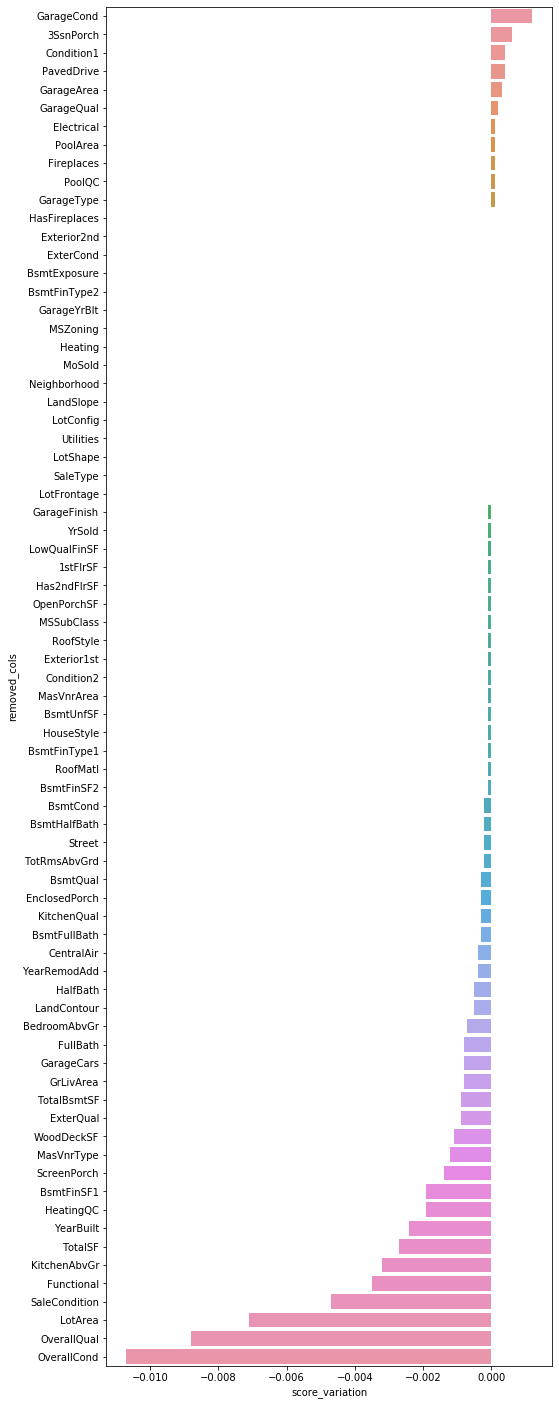

In [127]:
imp = evaluate_importance(df, df.columns, comparing_score)
plt.figure(figsize=(8, 25))
sns.barplot(x='score_variation', y='removed_cols', data=imp)

In [145]:
unimportant = list(imp[imp['score_variation']>-0.001].removed_cols)
print(unimportant)

['GarageCond', '3SsnPorch', 'Condition1', 'PavedDrive', 'GarageArea', 'GarageQual', 'Electrical', 'PoolArea', 'Fireplaces', 'PoolQC', 'GarageType', 'HasFireplaces', 'Exterior2nd', 'ExterCond', 'BsmtExposure', 'BsmtFinType2', 'GarageYrBlt', 'MSZoning', 'Heating', 'MoSold', 'Neighborhood', 'LandSlope', 'LotConfig', 'Utilities', 'LotShape', 'SaleType', 'LotFrontage', 'GarageFinish', 'YrSold', 'LowQualFinSF', '1stFlrSF', 'Has2ndFlrSF', 'OpenPorchSF', 'MSSubClass', 'RoofStyle', 'Exterior1st', 'Condition2', 'MasVnrArea', 'BsmtUnfSF', 'HouseStyle', 'BsmtFinType1', 'RoofMatl', 'BsmtFinSF2', 'BsmtCond', 'BsmtHalfBath', 'Street', 'TotRmsAbvGrd', 'BsmtQual', 'EnclosedPorch', 'KitchenQual', 'BsmtFullBath', 'CentralAir', 'YearRemodAdd', 'HalfBath', 'LandContour', 'BedroomAbvGr', 'FullBath', 'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'ExterQual']


In [128]:
# def reg_train(feature):
#     sns.regplot(x=feature, y="SalePrice", data=pd.concat([df[:train_num][[feature]], saleprice], axis=1))
def box_train(feature):
    sns.boxplot(x=feature, y="SalePrice", data=pd.concat([df[:train_num][[feature]], saleprice], axis=1))

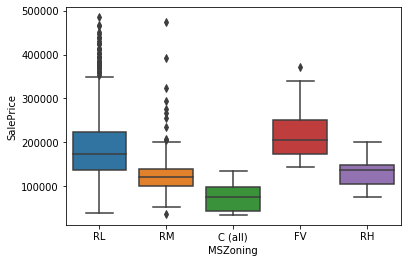

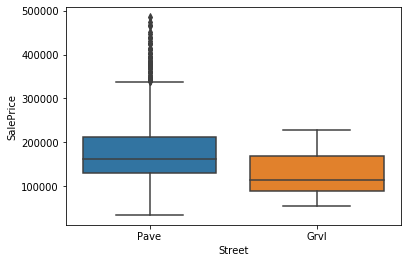

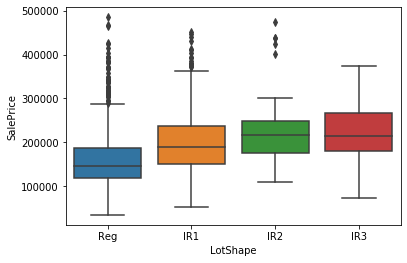

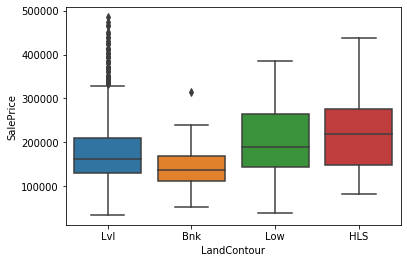

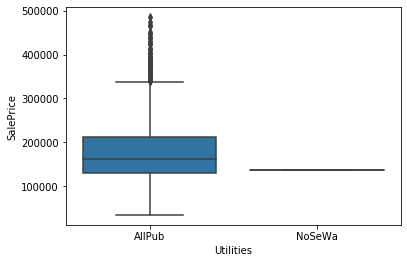

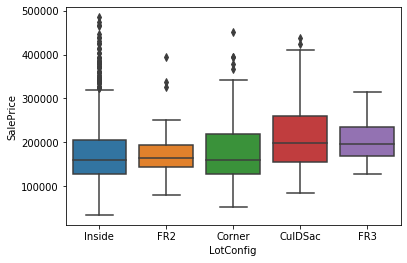

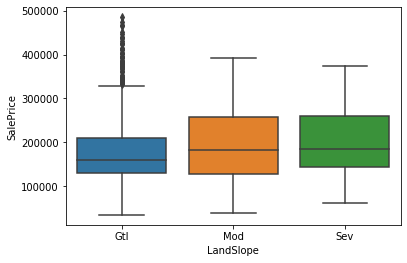

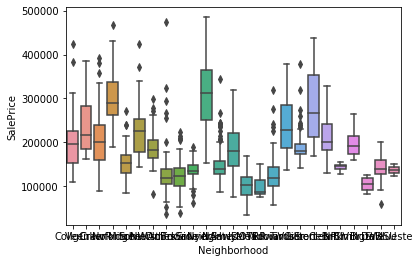

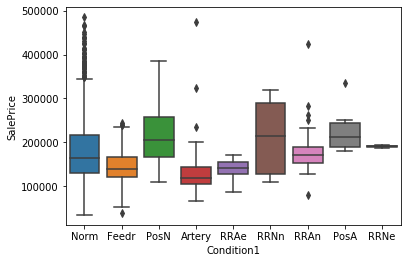

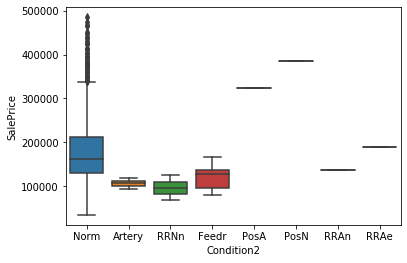

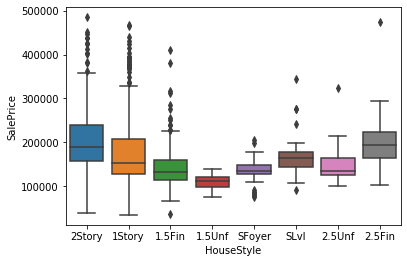

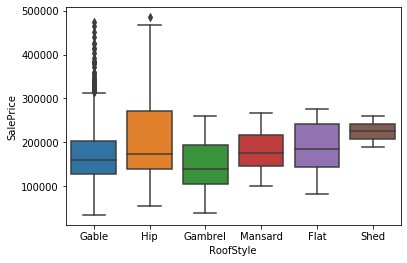

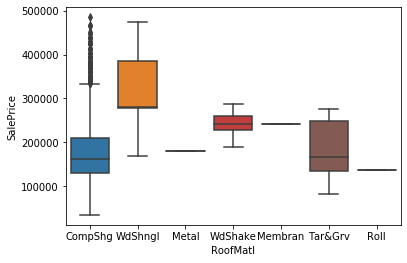

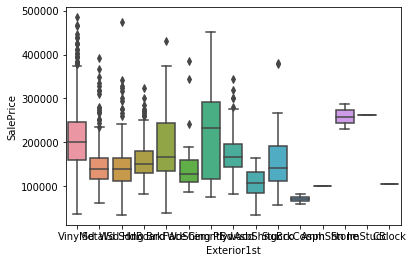

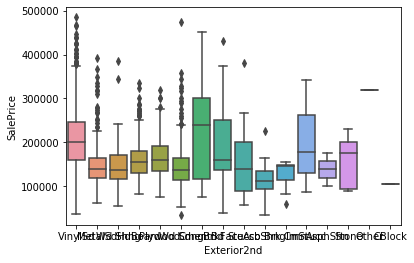

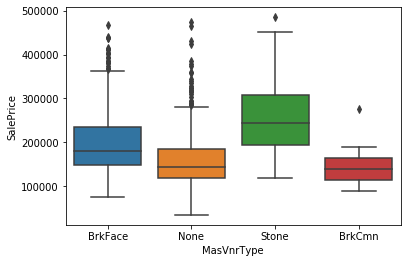

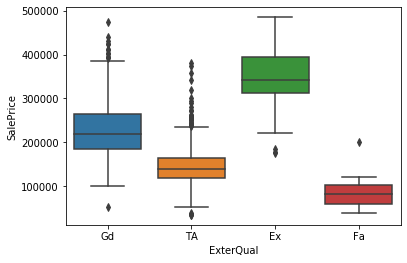

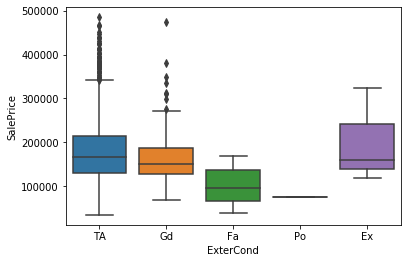

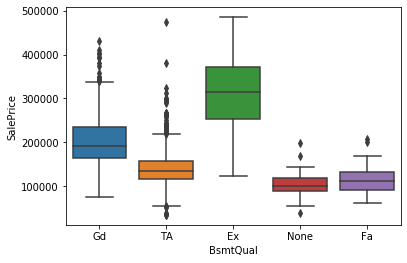

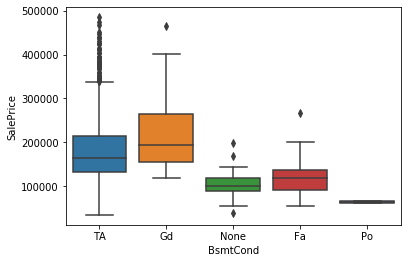

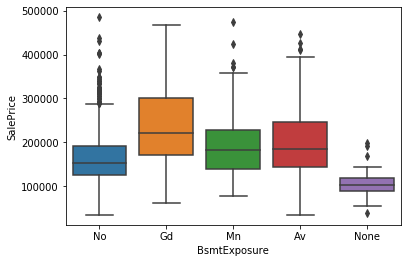

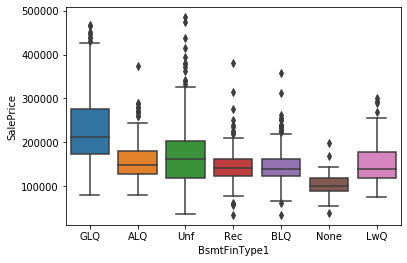

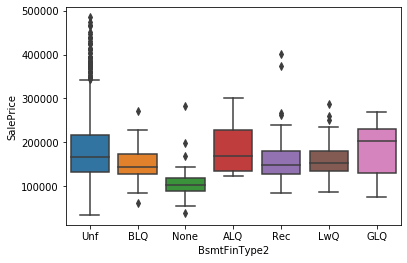

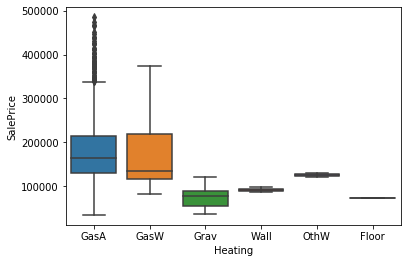

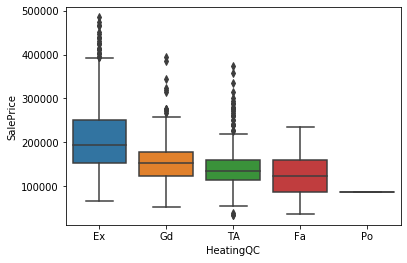

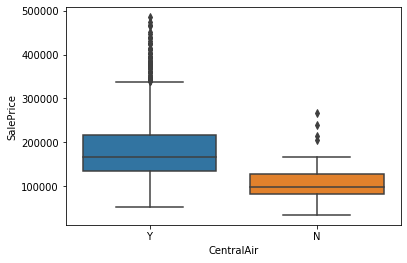

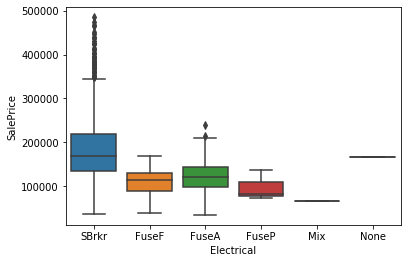

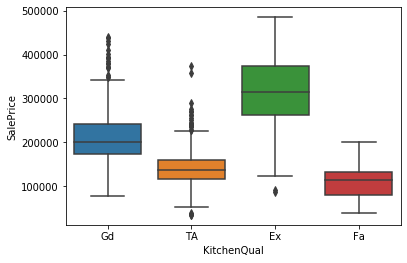

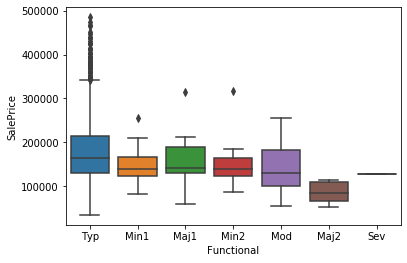

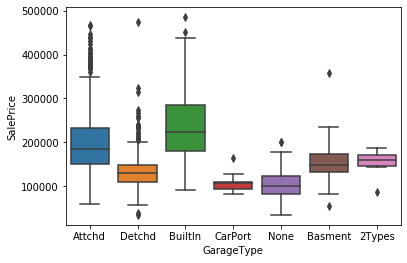

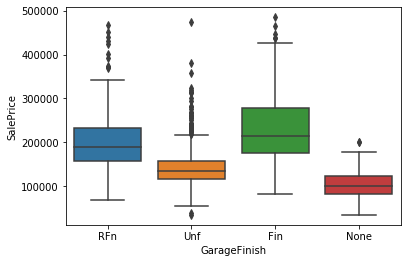

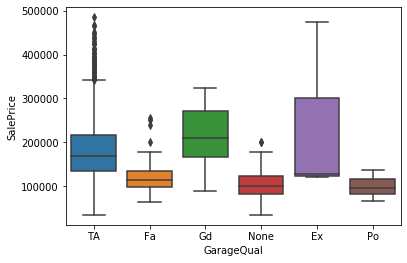

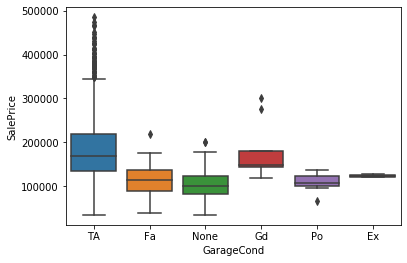

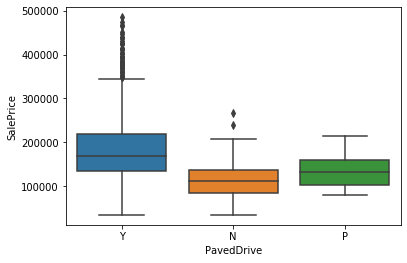

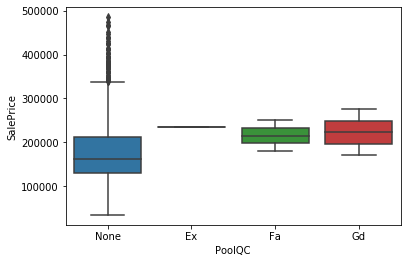

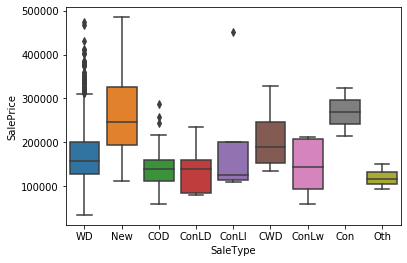

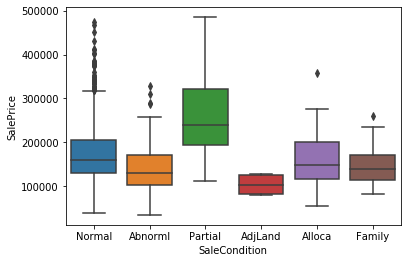

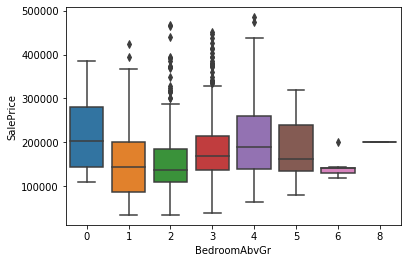

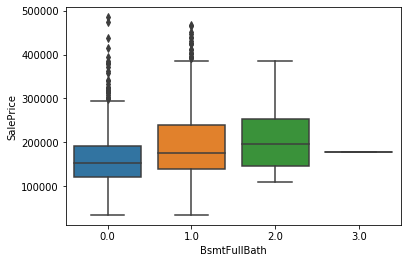

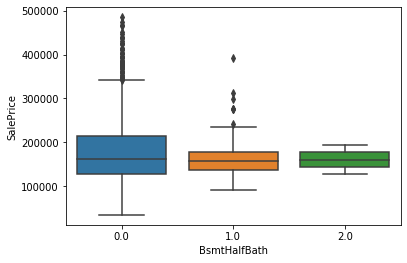

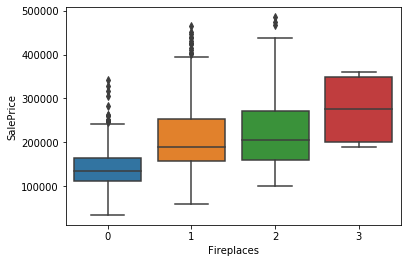

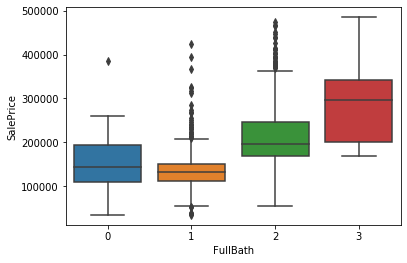

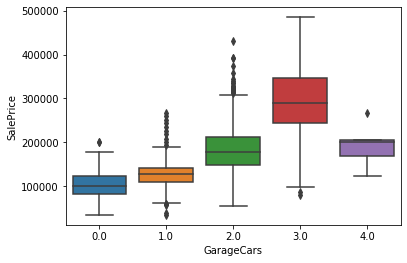

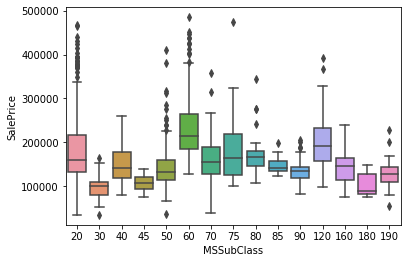

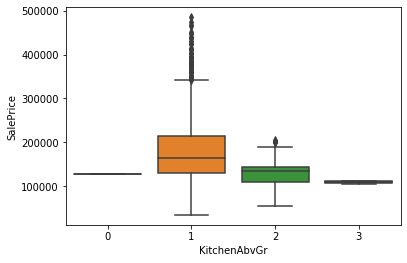

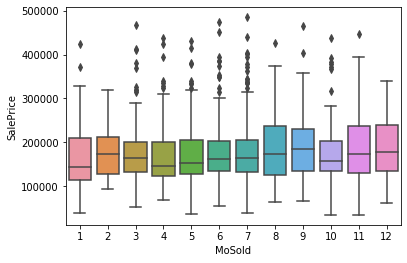

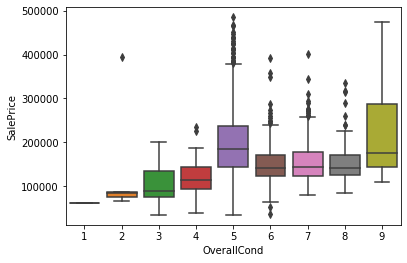

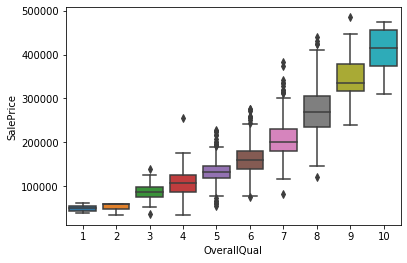

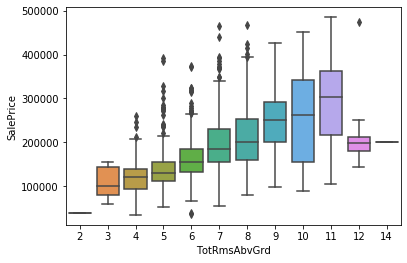

In [132]:
plt.rcParams.update({'figure.max_open_warning': 0})
for i in object_features:
    plt.figure()
    box_train(i)

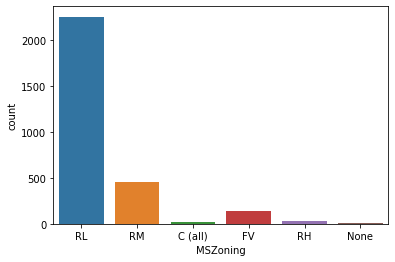

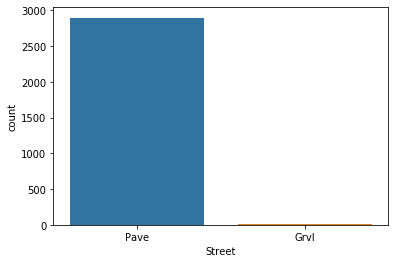

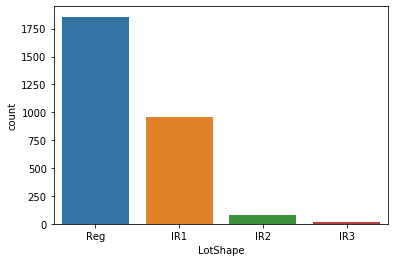

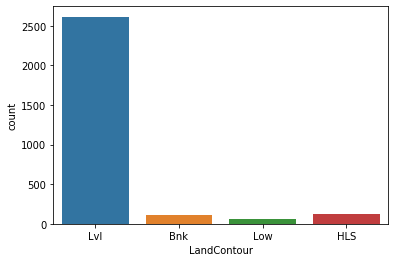

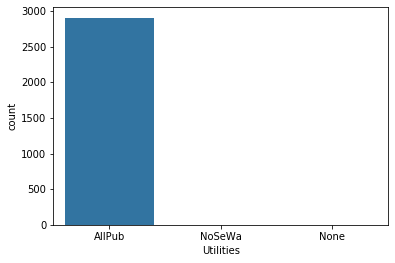

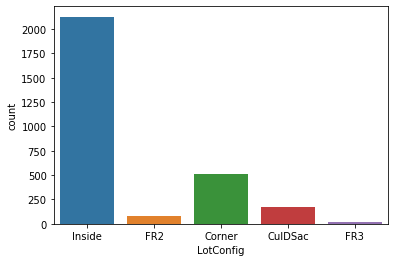

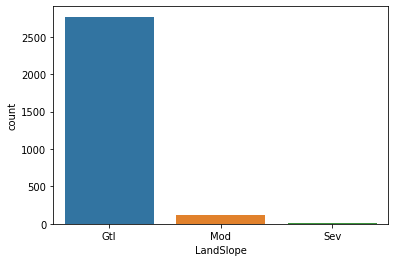

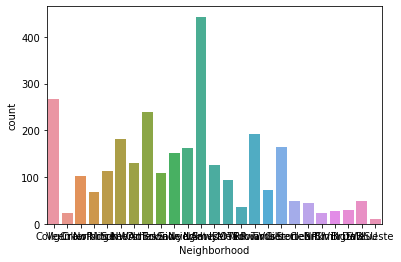

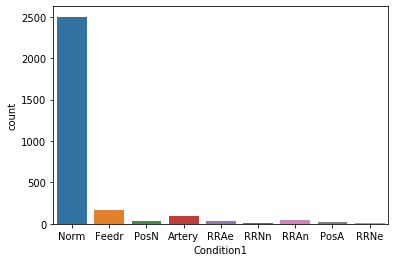

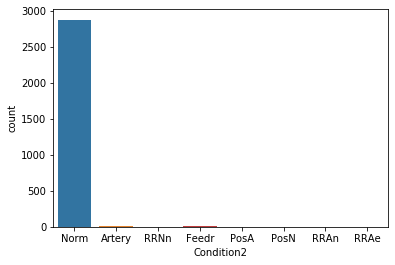

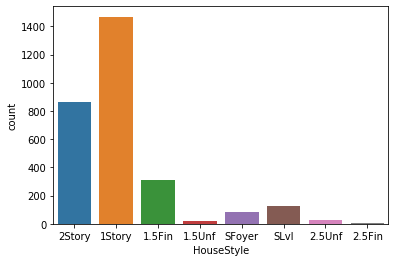

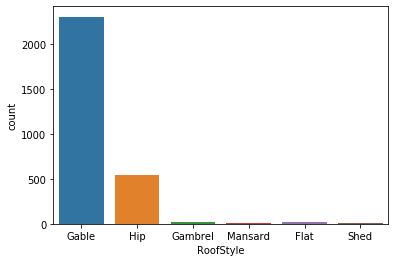

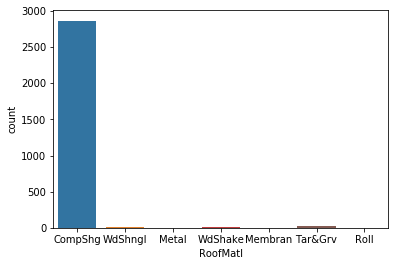

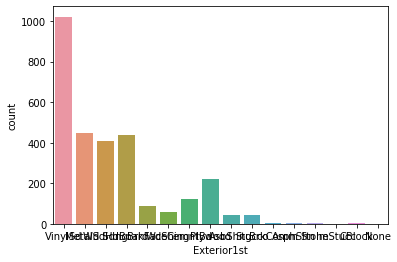

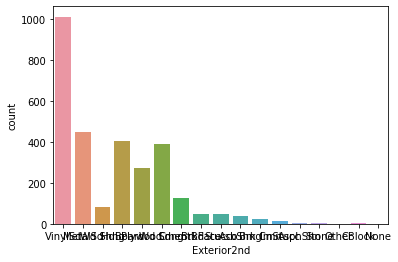

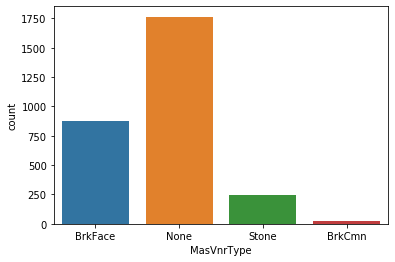

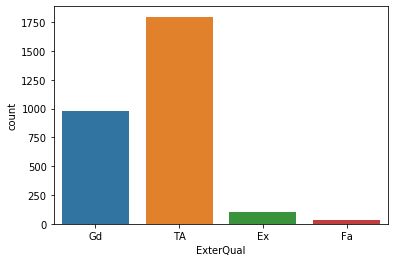

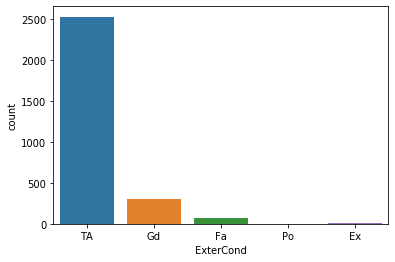

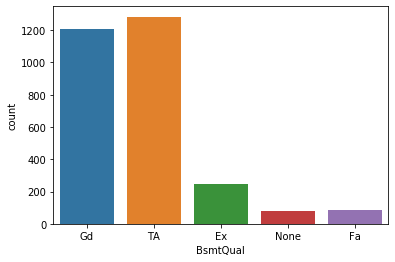

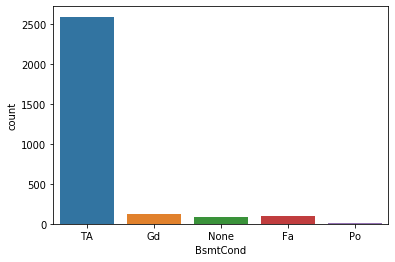

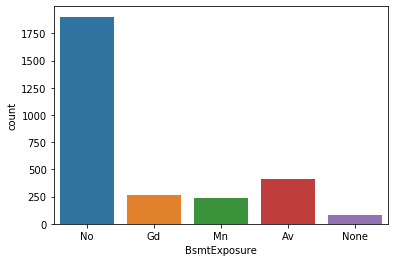

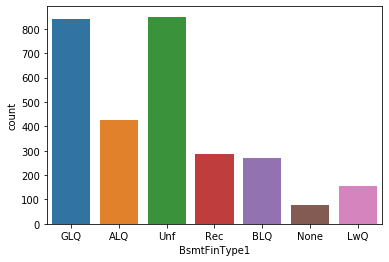

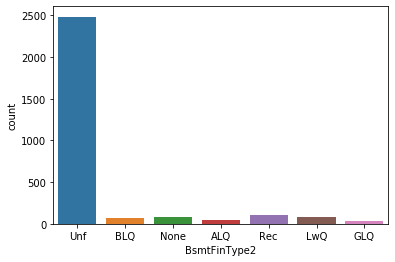

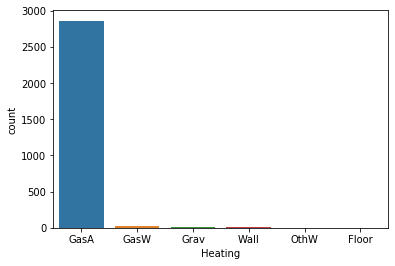

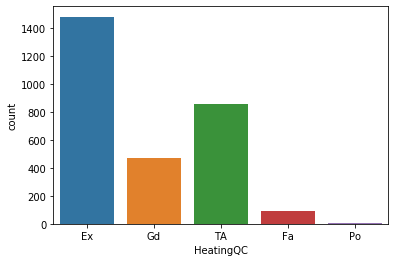

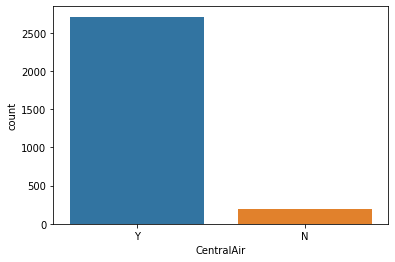

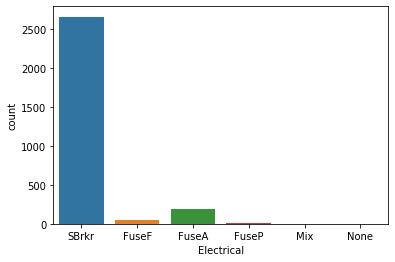

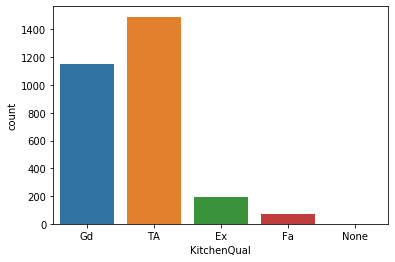

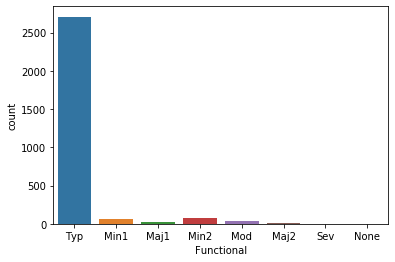

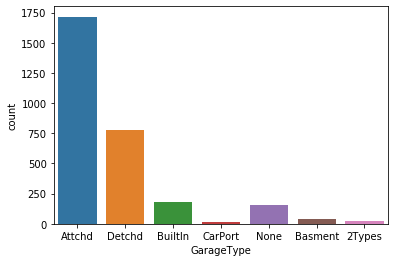

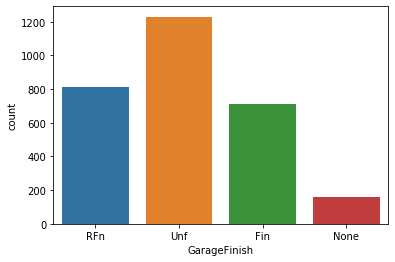

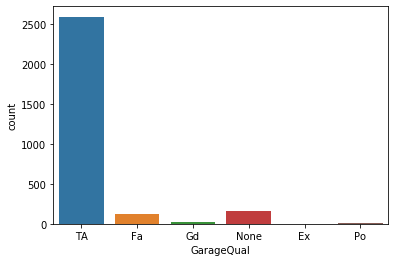

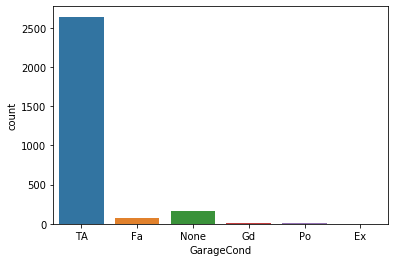

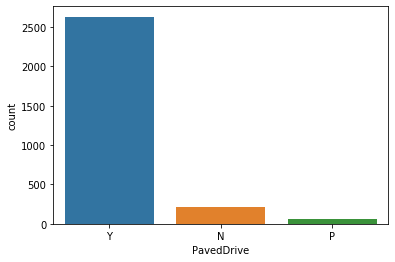

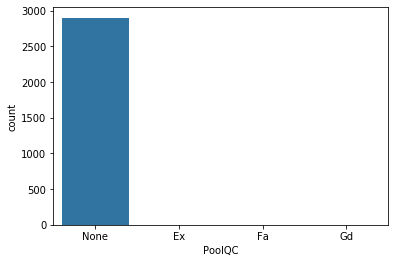

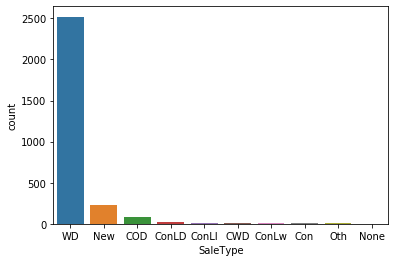

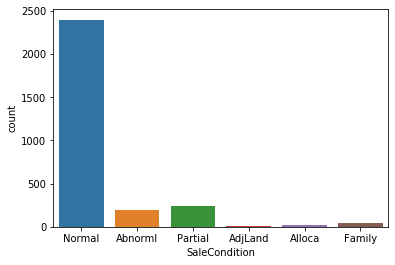

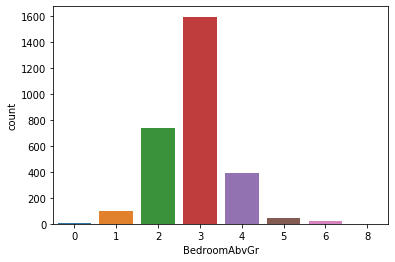

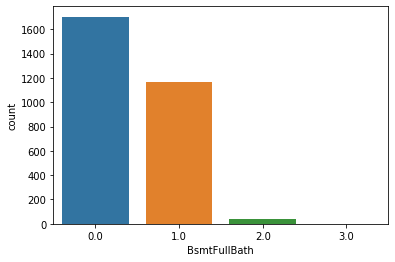

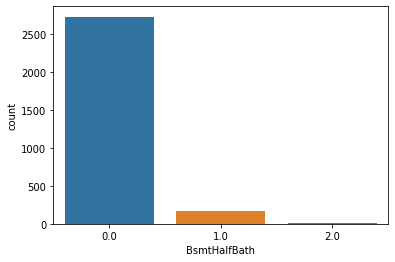

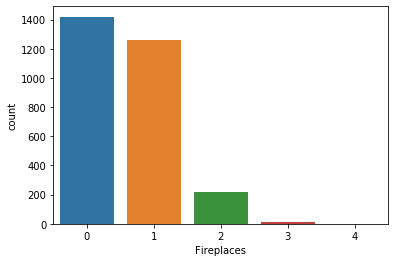

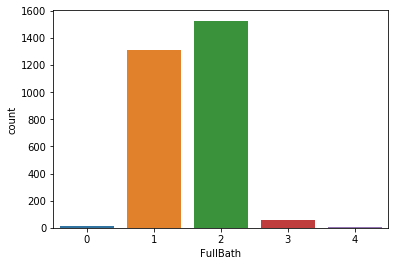

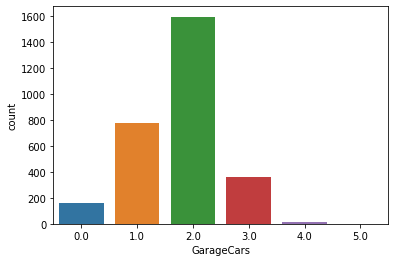

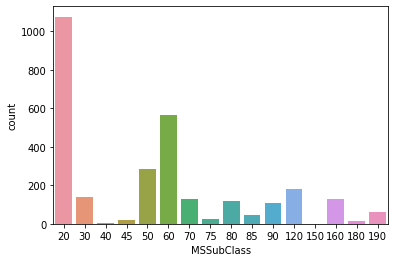

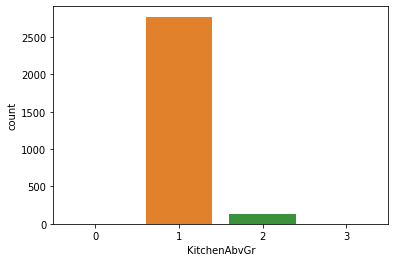

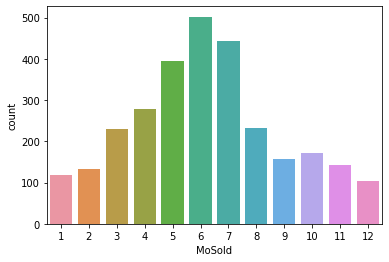

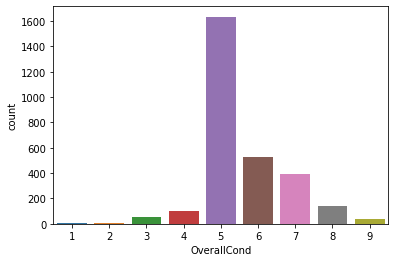

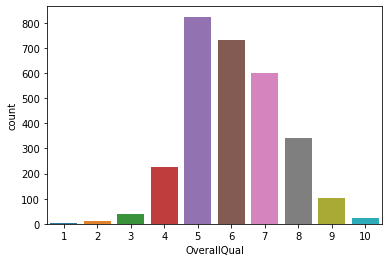

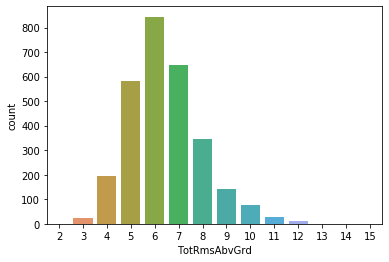

In [133]:
for i in object_features:
    plt.figure()
    sns.countplot(i, data=df)

In [142]:
skew_object = ['Street', 'LandContour', 'Utilities', 'LandSlope', \
       'Condition1', 'Condition2', 'BldgType', 'RoofMatl', \
       'MasVnrType', 'ExterCond', 'BsmtCond', 'BsmtFinType2', \
       'Heating', 'CentralAir', 'Electrical', 'Functional', \
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', \
       'SaleType', 'BsmtHalfBath', 'KitchenAbvGr']

In [146]:
skew_unimportant = [value for value in skew_object if value in unimportant]

In [148]:
print(skew_unimportant)

['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'SaleType', 'BsmtHalfBath']


In [149]:
df_removal = generate_removal(df.drop(skew_unimportant, axis=1))
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.0013999999999999568

In [150]:
df = df.drop(skew_unimportant, axis=1)
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9227


In [161]:
from scipy.stats import skew
skew = pd.DataFrame(df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False))\
    .reset_index().rename(columns={0:'skewness', 'index':'feature'})
skew[skew.skewness>0.25]

,feature,skewness
0,PoolArea,16.312345
1,3SsnPorch,8.807975
2,LowQualFinSF,8.540895
3,ScreenPorch,2.961882
4,BsmtFinSF2,2.461169
5,EnclosedPorch,1.954864
6,HalfBath,0.588479
7,MasVnrArea,0.543888
8,Has2ndFlrSF,0.293339


In [160]:
max_skew = ['PoolArea', '3SsnPorch', 'LowQualFinSF']

In [162]:
df_removal = generate_removal(df.drop(max_skew, axis=1))
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.0004

In [164]:
df = df.drop(max_skew, axis=1)
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, linear)
print(comparing_score)

0.9231


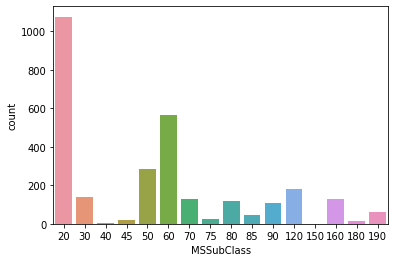

In [165]:
sns.countplot('MSSubClass', data=df)

In [176]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SaleCondition,TotalSF,Has2ndFlrSF,HasFireplaces
0,60,RL,4.189655,9.042040,Reg,Inside,CollgCr,2Story,7,5,...,0.000000,4.127134,0.000000,0.0,2,2008,Normal,7.850493,1,0
1,20,RL,4.394449,9.169623,Reg,FR2,Veenker,1Story,6,8,...,5.700444,0.000000,0.000000,0.0,5,2007,Normal,7.833996,0,1
2,60,RL,4.234107,9.328212,IR1,Inside,CollgCr,2Story,7,5,...,0.000000,3.761200,0.000000,0.0,9,2008,Normal,7.903596,1,1
3,70,RL,4.110874,9.164401,IR1,Corner,Crawfor,2Story,7,5,...,0.000000,3.583519,5.609472,0.0,2,2006,Abnorml,7.813592,1,1
4,60,RL,4.442651,9.565284,IR1,FR2,NoRidge,2Story,8,5,...,5.262690,4.442651,0.000000,0.0,12,2008,Normal,8.114923,1,1


In [166]:
bad_ordinal = ['MoSold', 'KitchenAbvGr', 'OverallCond', 'MSSubClass']

# Mean Encoder

In [173]:
# 分開處理類別/數值欄位
object_features = list(df.select_dtypes(include=["object"]).columns)
numeric_features = list(df.select_dtypes(exclude=["object"]).columns)
for i in bad_ordinal:
    object_features.append(i)
    numeric_features.remove(i)

In [167]:
list(df[:train_num]['MSZoning'].unique())

['RL', 'RM', 'C (all)', 'FV', 'RH']

In [175]:
print(object_features)

['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'SaleCondition', 'MoSold', 'KitchenAbvGr', 'OverallCond', 'MSSubClass']


In [177]:
# 確認 test data 的 feature 的 catalog 在 train data 都存在
for i in object_features:
    train_catalog = list(df[:train_num][i].unique())
    test_catalog = list(df[train_num:][i].unique())
    dif = list(set(test_catalog) - set(train_catalog))
    if dif !=[]:
        print(i, dif)

MSZoning ['None']
Exterior1st ['None']
Exterior2nd ['None']
KitchenQual ['None']
Functional ['None']
MSSubClass [150]


In [181]:
df[df.MSSubClass==150]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SaleCondition,TotalSF,Has2ndFlrSF,HasFireplaces
1358,150,RL,4.400603,7.438972,Reg,Inside,ClearCr,1.5Fin,7,5,...,5.241747,3.610918,0.0,5.303305,4,2006,Normal,7.596392,1,0


In [182]:
mode(df.MSSubClass)

20

In [184]:
df.MSSubClass = df.MSSubClass.apply(lambda x:x if x!=150 else mode(df.MSSubClass))

In [185]:
df[df.MSSubClass==150]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SaleCondition,TotalSF,Has2ndFlrSF,HasFireplaces


In [97]:
# # 均值編碼 + 線性迴歸
# # 橫向連接
# data = pd.concat([df[:train_num], train_Y], axis=1)
# f_mapping={}
# for c in object_features:
#     # 取 c 各類別 'SalePrice' 的平均值
#     mean_df = data.groupby([c])['SalePrice'].mean().reset_index()
#     mean_df.columns = [c, f'{c}_mean']
#     f_mapping[c]=mean_df
#     # 將原資料 join 計算出的平均值
#     data = pd.merge(data, mean_df, on=c, how='left')
#     # 用 c_mean 取代掉 c
#     data = data.drop([c] , axis=1)
# data.drop('SalePrice', axis=1, inplace=True)

In [178]:
def mapping_generator(price, mapping_features):
    data = pd.concat([df[:train_num], price], axis=1)
    f_mapping={}
    for c in mapping_features:
        # 取 c 各類別 'SalePrice' 的平均值
        mean_df = data.groupby([c])['SalePrice'].median().reset_index()
        mean_df.columns = [c, f'{c}_mean']
        f_mapping[c]=mean_df
    return f_mapping

In [179]:
f_mapping = mapping_generator(saleprice, ['Neighborhood'])

In [180]:
f_mapping['Neighborhood'].head()

,Neighborhood,Neighborhood_mean
0,Blmngtn,191000.0
1,Blueste,137500.0
2,BrDale,106000.0
3,BrkSide,124300.0
4,ClearCr,200250.0


# Apply Mean Encoder

In [186]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, LinearRegression())
print(comparing_score)

0.9231


In [187]:
def medianencoder_generator(df, price, mapping_features):
    df_medianencoder = df.copy()
    f_mapping = mapping_generator(price, mapping_features)
    for c in f_mapping.keys():
        median_df = f_mapping[c]
        # 將原資料 join 計算出的平均值
        df_medianencoder = pd.merge(df_medianencoder, median_df, on=c, how='left')
        # 用 c_mean 取代掉 c
        df_medianencoder = df_medianencoder.drop([c] , axis=1)
        df_medianencoder.rename(columns={f'{c}_mean':c}, inplace=True)
    for i in df_medianencoder.isnull().sum()[lambda x:x>0].index:
        df_medianencoder = df_medianencoder.fillna(df_medianencoder[i].mean())
    return df_medianencoder

In [188]:
def evaluate_importance(df, evaluate_columns, comparing_score):
    scores = [evaluate_train(generate_removal(df.drop(i, axis=1)), LinearRegression()) for i in evaluate_columns]
    imp = pd.DataFrame({'removed_cols':evaluate_columns, \
                        'score_variation':[comparing_score-i for i in scores]}).sort_values\
                        ('score_variation',ascending = False)
    return imp

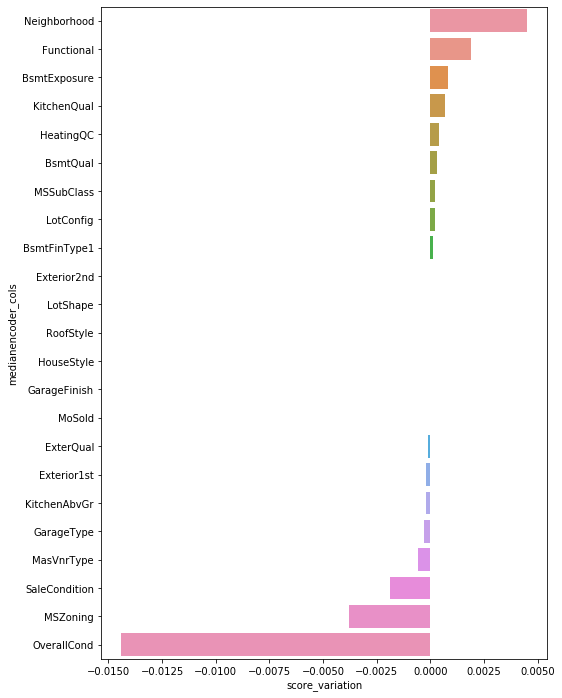

In [194]:
m = []
for c in object_features:
    df_removal = generate_removal(medianencoder_generator(df, train_Y, [c]))
    medianencoder_score = evaluate_train(df_removal, LinearRegression())
    # print(c, round(meanencoder_score - comparing_score, 4))
    m.append(round(medianencoder_score - comparing_score, 4))
medianencoder_affect = pd.DataFrame({'medianencoder_cols':object_features, \
                        'score_variation':m}).sort_values('score_variation',ascending = False)
plt.figure(figsize=(8, 12))
sns.barplot(x='score_variation', y='medianencoder_cols', data=medianencoder_affect)

In [195]:
medianencoder_affect[medianencoder_affect.score_variation>0]

,medianencoder_cols,score_variation
3,Neighborhood,0.0045
15,Functional,0.0019
11,BsmtExposure,0.0008
14,KitchenQual,0.0007
13,HeatingQC,0.0004
10,BsmtQual,0.0003
22,MSSubClass,0.0002
2,LotConfig,0.0002
12,BsmtFinType1,0.0001


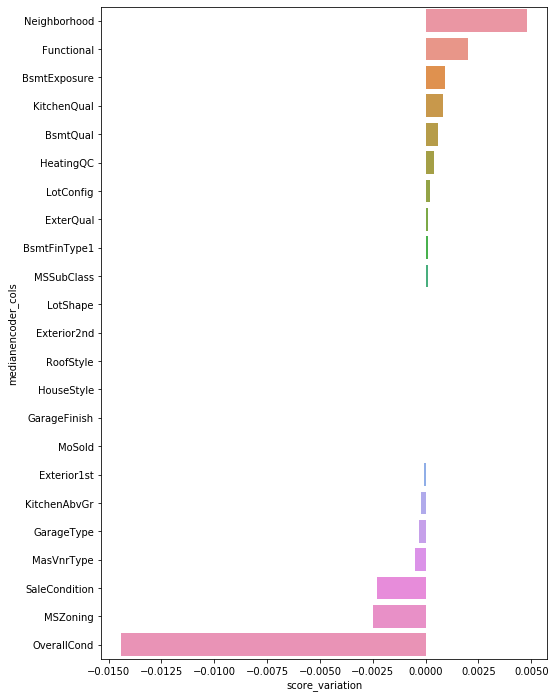

In [196]:
m = []
for c in object_features:
    df_removal = generate_removal(medianencoder_generator(df, saleprice, [c]))
    medianencoder_score = evaluate_train(df_removal, LinearRegression())
    # print(c, round(meanencoder_score - comparing_score, 4))
    m.append(round(medianencoder_score - comparing_score, 4))
medianencoder_affect = pd.DataFrame({'medianencoder_cols':object_features, \
                        'score_variation':m}).sort_values('score_variation',ascending = False)
plt.figure(figsize=(8, 12))
sns.barplot(x='score_variation', y='medianencoder_cols', data=medianencoder_affect)

In [197]:
medianencoder_affect[medianencoder_affect.score_variation>0]

,medianencoder_cols,score_variation
3,Neighborhood,0.0048
15,Functional,0.0020
11,BsmtExposure,0.0009
14,KitchenQual,0.0008
10,BsmtQual,0.0006
13,HeatingQC,0.0004
2,LotConfig,0.0002
9,ExterQual,0.0001
12,BsmtFinType1,0.0001
22,MSSubClass,0.0001


In [211]:
m_list = ['Neighborhood', 'Functional', 'BsmtExposure', 'KitchenQual', 'HeatingQC', 'LotConfig']
df_removal = generate_removal(medianencoder_generator(df, saleprice, m_list))
round(evaluate_train(df_removal, linear) - comparing_score, 4)

0.0091

In [212]:
df = generate_removal(medianencoder_generator(df, saleprice, m_list))

In [214]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, LinearRegression())
print(comparing_score)

0.9322


In [215]:
# pred
upld = tmp_pred(df_removal, linear)
upld.SalePrice = upld.SalePrice.apply(lambda x:34000 if x<34000 else x)
upld.SalePrice = upld.SalePrice.apply(lambda x:600000 if x>600000 else x)

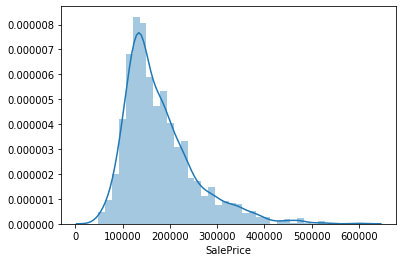

In [216]:
sns.distplot(upld.SalePrice)

In [217]:
# 0.12693
upld.to_csv('housing_linear.csv', index=False)

In [219]:
upld = tmp_pred(df_removal, gdbt)
upld.SalePrice = upld.SalePrice.apply(lambda x:34000 if x<34000 else x)
upld.SalePrice = upld.SalePrice.apply(lambda x:600000 if x>600000 else x)

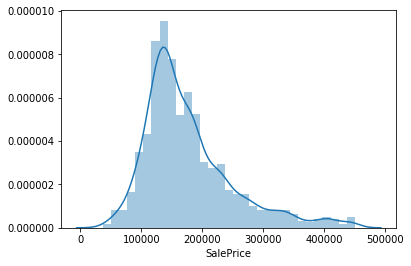

In [220]:
sns.distplot(upld.SalePrice)

In [221]:
# 0.13302(?)
upld.to_csv('housing_gdbt.csv', index=False)

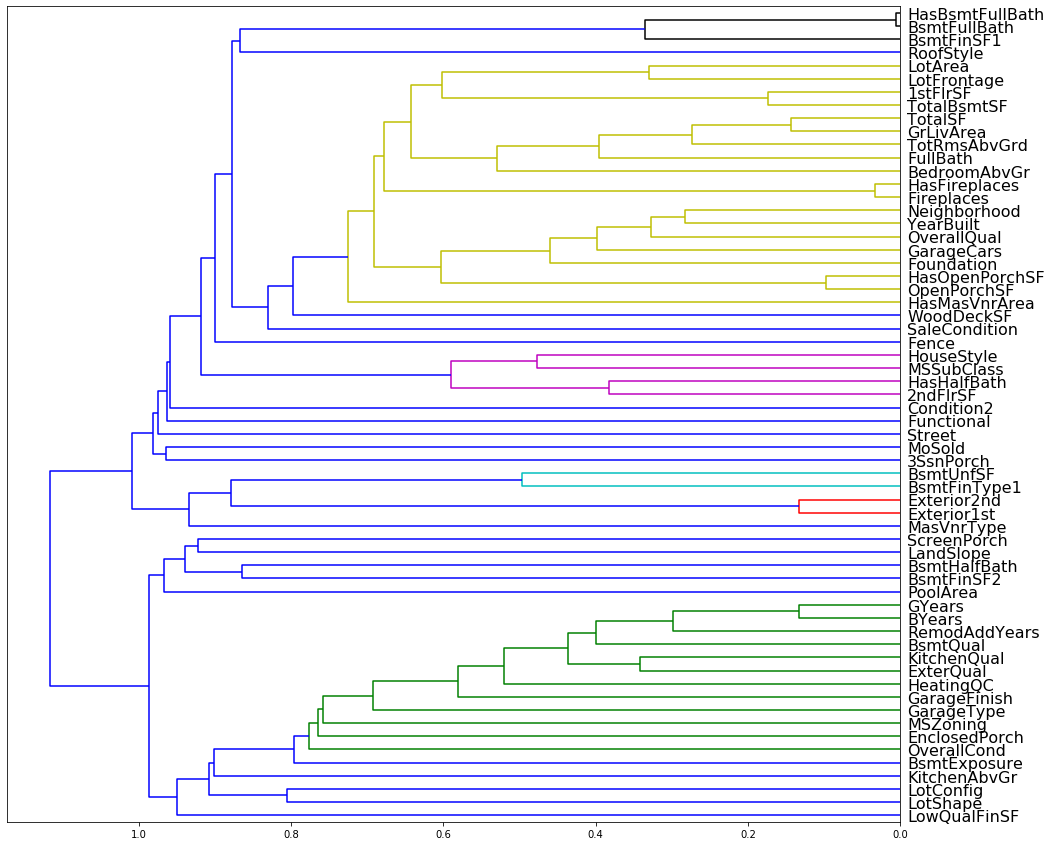

In [67]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [80]:
redundant = ['HasBsmtFullBath', 'Fireplaces', 'OpenPorchSF', 'GYears', 'Exterior2nd']

In [179]:
# redu_unimportant = [value for value in redundant if value in unimportant]
# print(redu_unimportant)
# df_removal = generate_removal(df.drop(redu_unimportant, axis=1))
# evaluate_train(df_removal, LinearRegression()) - comparing_score

In [83]:
df = df.drop(redundant, axis=1)

In [103]:
df_removal = generate_removal(df)
comparing_score = evaluate_train(df_removal, LinearRegression())
print(comparing_score)

0.9221703943680957


['MSSubClass', 'LotFrontage', 'LotArea', 'BsmtFinSF2', '1stFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']


0.006366718060758725

0.926781029430152


In [186]:
# 0.12570
upld_t = tmp_pred(df_removal, LinearRegression())
upld_t.SalePrice = upld_t.SalePrice.apply(lambda x:34000 if x<34000 else x)
upld_t.SalePrice = upld_t.SalePrice.apply(lambda x:600000 if x>600000 else x)
upld_t.to_csv('housing_r_d.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


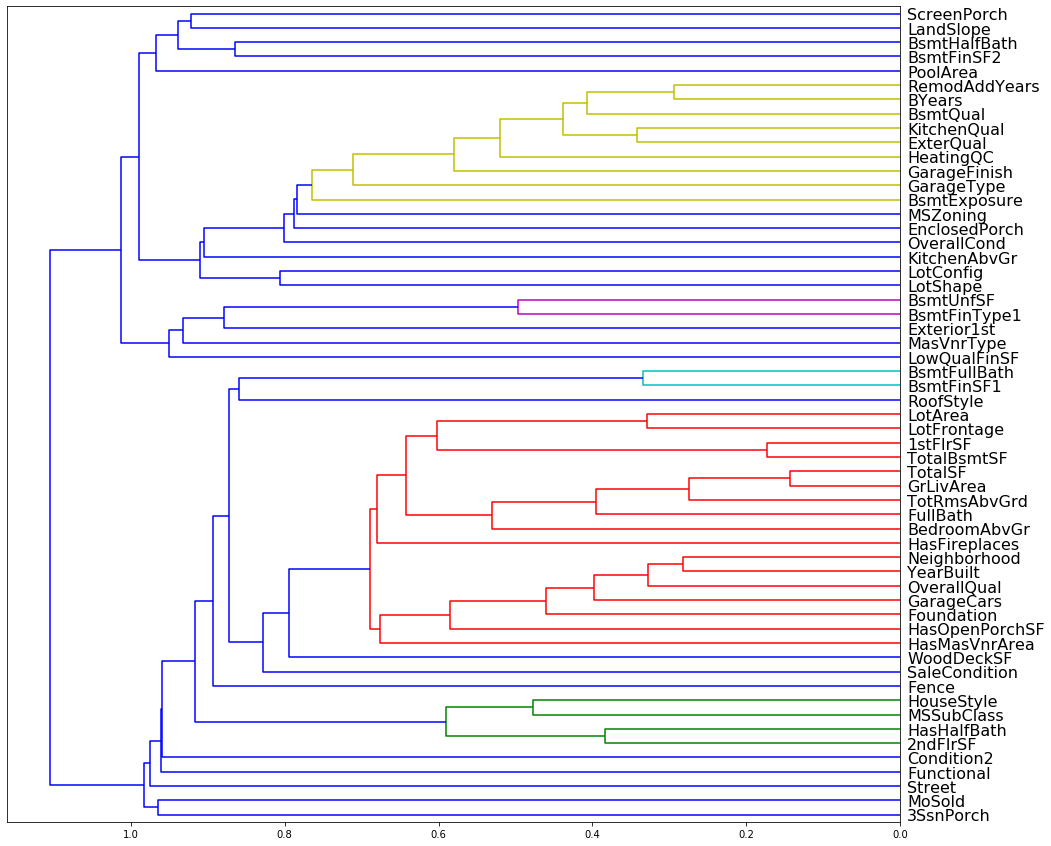

In [190]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

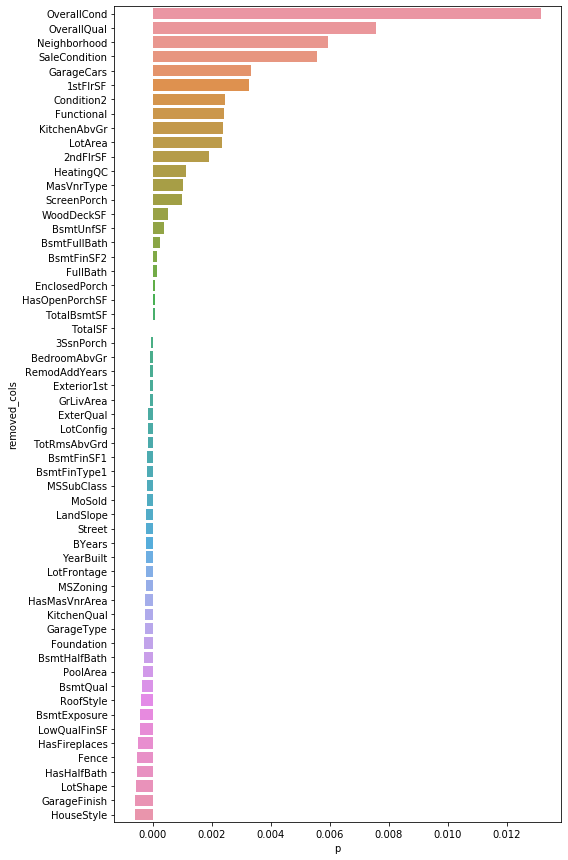

In [193]:
imp = evaluate_importance(df, df.columns, comparing_score)
plt.figure(figsize=(8, 15))
sns.barplot(x='p', y='removed_cols', data=imp)

# Evaluation

In [91]:
# Initialize models
lr = LinearRegression(
    n_jobs = -1
)

rd = Ridge(
    alpha = 4.84
)

rf = RandomForestRegressor(
    n_estimators = 12,
    max_depth = 3,
    n_jobs = -1
)

gb = GradientBoostingRegressor(
    n_estimators = 40,
    max_depth = 2
)

nn = MLPRegressor(
    hidden_layer_sizes = (90, 90),
    alpha = 2.75
)

In [104]:
model = StackingRegressor(
    regressors=[gb, nn, rd],
    meta_regressor=lr
)

In [105]:
df_removal = generate_removal(df)
evaluate_train(df_removal, model) - comparing_score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-0.051573069955288764

In [106]:
df_removal = generate_removal(df)
evaluate_train(df_removal, XGBRegressor()) - comparing_score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


-0.014043523627767174

In [70]:
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X, 因為不論何種特徵工程, 都需要對 train / test 做同樣處理
# 常見並簡便的方式就是 - 先將 train / test 接起來, 做完後再拆開, 不然過程當中往往需要將特徵工程部分寫兩次, 麻煩且容易遺漏
# 在較複雜的特徵工程中尤其如此, 若實務上如果碰到 train 與 test 需要分階段進行, 則通常會另外寫成函數處理
df = df_numeric.copy()
train_X = df[:train_num]
test_X = df[train_num:]

In [71]:
print(train_X.shape, test_X.shape)

(1460, 74) (1459, 74)


In [107]:
estimator = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_X, np.expm1(train_Y), test_size=0.2, random_state=42)

In [129]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

0.8624965651010591


In [142]:
# 可以看回歸模型的參數值
print('Coefficients: ', estimator.coef_)

# 預測值與實際值的差距，使用 MSE
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

print("R squared error: %.2f"
      % r2_score(y_test, y_pred))

Coefficients:  [-2.14133010e+02 -1.46814842e+02  1.56242025e-01  9.60840398e+03
  4.61781427e+03 -1.12286803e+01 -1.05808292e+02  2.24644343e+01
  5.49797646e+00 -1.95909095e+00 -4.85740736e+00 -1.31852239e+00
  1.29288836e+01  6.51755955e+00  1.43792959e+01  3.38257382e+01
  6.42571473e+03 -9.19857730e+02  3.14546292e+03  2.62474334e+03
 -2.74965520e+03 -1.55313984e+04  3.95917567e+03  5.10741708e+03
 -1.90691117e+01  7.33228869e+03  8.23113042e+00  1.28997249e+01
  3.04403894e+00  1.16370505e+01  4.31159498e+01  5.44623606e+01
  1.45072161e+00  2.94633629e-02 -4.97157612e+02  6.67622032e+02
 -2.61222424e+03  5.31930861e+04 -3.44024257e+03  6.55592723e+04
  4.35521285e+05  3.81252785e+04  5.81220940e+04  5.00385284e+04
  3.65300793e+04 -6.26644552e+04 -4.11988225e+04 -1.72093570e+04
  3.39654097e+04  4.35928291e+04  3.67484758e+03  6.85245931e+03
 -1.31995340e+04  1.51275695e+04 -1.04243542e+04  3.98924841e+03
  2.79742170e+04 -1.23565032e+03  3.82531752e+04  1.95466510e+03
 -2.996931

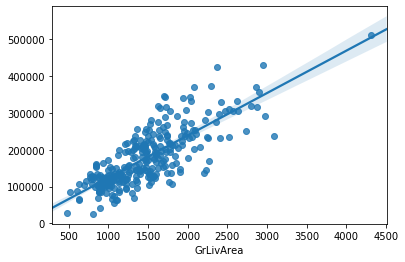

In [144]:
# 畫出回歸模型與實際資料的分佈
sns.regplot(x = X_test['GrLivArea'], y=y_pred)
plt.show()